## Exercise: Using LSTMs to Classify the 20 Newsgroups Data Set
### Modified by Darshan Patel
The 20 possible groups are:

`comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x	rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey	
sci.crypt
sci.electronics
sci.med
sci.space
misc.forsale	
talk.politics.misc
talk.politics.guns
talk.politics.mideast	
talk.religion.misc
alt.atheism
soc.religion.christian`

As you can see, some pairs of groups may be quite similar while others are very different.

The data is given as a designated training set of size 11314 and test set of size 7532.  The 20 categories are represented in roughly equal proportions, so the baseline accuracy is around 5%.


To begin, review the code below.  This will walk you through the basics of loading in the 20 newsgroups data, loading in the GloVe data, building the word embedding matrix, and building the LSTM model.

After we build the first LSTM model, it will be your turn to build one and play with the parameters.

In [1]:
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

import keras

from sklearn.datasets import fetch_20newsgroups

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/Users/darshanpatel/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
max_features = 20000
seq_length = 30  # How long to make our word sequences
batch_size = 32



In [3]:
# Download the 20 newsgroups data - there is already a designated "train" and "test" set

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')



In [4]:
len(newsgroups_train.data), len(newsgroups_test.data)

(11314, 7532)

In [5]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(newsgroups_train.data)

In [6]:
sequences_train = tokenizer.texts_to_sequences(newsgroups_train.data)
sequences_test = tokenizer.texts_to_sequences(newsgroups_test.data)

In [7]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 134142 unique tokens.


In [8]:
x_train = pad_sequences(sequences_train, maxlen=seq_length)
x_test = pad_sequences(sequences_test, maxlen=seq_length)



In [9]:
x_train

array([[ 2908,   198,     3, ...,    35,    58,  7860],
       [  351,   138,   533, ...,   118,   441,    15],
       [    9,    33,     4, ...,   187,    84, 17015],
       ...,
       [   10,     1,  1787, ...,   349,   383,    31],
       [  115,   362,    67, ...,  7772,   486,   492],
       [ 4485, 13919,  1031, ...,   200,    38,  3826]], dtype=int32)

In [10]:
y_train = keras.utils.to_categorical(np.asarray(newsgroups_train.target))
y_test = keras.utils.to_categorical(np.asarray(newsgroups_test.target))

We will use the file glove.6B.100d.txt

We will be using the Glove pre-trained word vectors.  If you haven't already, please download them using this link:
(NOTE: this will start downloading an 822MB file)

http://nlp.stanford.edu/data/glove.6B.zip

Then unzip the file and fill your local path to the file in the code cell below.

We will use the file `glove.6B.100d.txt`

In [11]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Let's just look at a word embedding

In [12]:
dog_vec = embeddings_index['dog']
dog_vec

array([ 0.30817  ,  0.30938  ,  0.52803  , -0.92543  , -0.73671  ,
        0.63475  ,  0.44197  ,  0.10262  , -0.09142  , -0.56607  ,
       -0.5327   ,  0.2013   ,  0.7704   , -0.13983  ,  0.13727  ,
        1.1128   ,  0.89301  , -0.17869  , -0.0019722,  0.57289  ,
        0.59479  ,  0.50428  , -0.28991  , -1.3491   ,  0.42756  ,
        1.2748   , -1.1613   , -0.41084  ,  0.042804 ,  0.54866  ,
        0.18897  ,  0.3759   ,  0.58035  ,  0.66975  ,  0.81156  ,
        0.93864  , -0.51005  , -0.070079 ,  0.82819  , -0.35346  ,
        0.21086  , -0.24412  , -0.16554  , -0.78358  , -0.48482  ,
        0.38968  , -0.86356  , -0.016391 ,  0.31984  , -0.49246  ,
       -0.069363 ,  0.018869 , -0.098286 ,  1.3126   , -0.12116  ,
       -1.2399   , -0.091429 ,  0.35294  ,  0.64645  ,  0.089642 ,
        0.70294  ,  1.1244   ,  0.38639  ,  0.52084  ,  0.98787  ,
        0.79952  , -0.34625  ,  0.14095  ,  0.80167  ,  0.20987  ,
       -0.86007  , -0.15308  ,  0.074523 ,  0.40816  ,  0.0192

In [13]:
## This creates a matrix where the $i$th row gives the word embedding for the word represented by integer $i$.
## Essentially, these will be the "weights" for the Embedding Layer
## Rather than learning the weights, we will use these ones and "freeze" the layer

embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [14]:
embedding_matrix.shape

(134143, 100)

## LSTM Layer
`keras.layers.recurrent.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0)`

- Similar in structure to the `SimpleRNN` layer
- `units` defines the dimension of the recurrent state
- `recurrent_...` refers the recurrent state aspects of the LSTM
- `kernel_...` refers to the transformations done on the input



In [15]:
word_dimension = 100  # This is the dimension of the words we are using from GloVe
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            word_dimension,  
                            weights=[embedding_matrix],  # We set the weights to be the word vectors from GloVe
                            input_length=seq_length,
                            trainable=False))  # By setting trainable to False, we "freeze" the word embeddings.
model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(20, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           13414300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
Total params: 13,430,640
Trainable params: 16,340
Non-trainable params: 13,414,300
_________________________________________________________________


In [16]:
rmsprop = keras.optimizers.RMSprop(lr = .002)

model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [18]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=20,
          validation_data=(x_test, y_test))

Train on 11314 samples, validate on 7532 samples
Epoch 1/20
11314/11314 [==============================] - 8s 724us/step - loss: 2.3044 - acc: 0.2861 - val_loss: 2.1739 - val_acc: 0.3210
Epoch 2/20
11314/11314 [==============================] - 8s 734us/step - loss: 2.1087 - acc: 0.3521 - val_loss: 2.0382 - val_acc: 0.3664
Epoch 3/20
11314/11314 [==============================] - 8s 737us/step - loss: 1.9903 - acc: 0.3866 - val_loss: 1.9798 - val_acc: 0.3864
Epoch 4/20
11314/11314 [==============================] - 8s 735us/step - loss: 1.8980 - acc: 0.4174 - val_loss: 1.9379 - val_acc: 0.4019
Epoch 5/20
11314/11314 [==============================] - 8s 719us/step - loss: 1.8288 - acc: 0.4376 - val_loss: 1.8932 - val_acc: 0.4156
Epoch 6/20
11314/11314 [==============================] - 8s 724us/step - loss: 1.7712 - acc: 0.4523 - val_loss: 1.8456 - val_acc: 0.4311
Epoch 7/20
11314/11314 [==============================] - 8s 716us/step - loss: 1.7223 - acc: 0.4723 - val_loss: 1.8438 - v

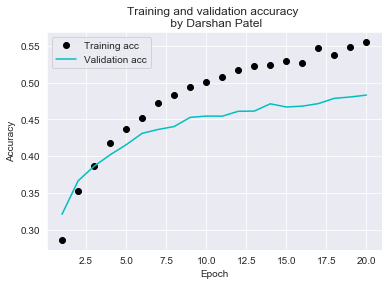

In [25]:
history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")


plt.plot(epochs, acc_values, 'ko', label='Training acc')
plt.plot(epochs, val_acc_values, 'c', label='Validation acc')
plt.title('Training and validation accuracy \n by Darshan Patel')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Exercise

In [ ]:
from keras.layers import SimpleRNN
from keras import initializers


In [ ]:
model_2 = Sequential()
model_2.add(Embedding(len(word_index) + 1,
                            word_dimension,
                      trainable=____)) 
model_2.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2))
model_2.add(Dense(20, activation='softmax'))

model.summary()

In [ ]:
rmsprop = keras.optimizers.RMSprop(lr = .002)

model_2.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [ ]:
model_2.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=20,
          validation_data=(x_test, y_test))